In [1]:
import uavgeo as ug
import geopandas as gpd
import rioxarray as rxr
import numpy as np
import ultralytics
import xarray as xr
import matplotlib.pyplot as plt
import cv2
import os

c:\users\judoj\documents\programming\uavgeo\uavgeo\compute\products.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Geographic DATASET TRAIN/VAL/TEST Splitting
For pix2pix we want a style a and style b dataset: so we create an RGB and NDVI dataset. splitted on chips in the larger orthomosaic.

This requires 3 steps:
1. Loading data
2. Defining the splits in space
3. chipping the dataset and saving the imgs to disk

In [3]:
os.chdir("../")

In [4]:
os.getcwd()

'C:\\Users\\judoj\\Documents\\programming\\style_transfer_NDVI'

## 1. Loading datasets
Load the orthomosaic
and some other geopgrahic data, in which the quality is 100% sure: the three rows of the vineyard that are covered by the flight path.



In [4]:
ortho = rxr.open_rasterio("data/orthos/ms_2021.tif", xr_name = "ms_sfm")
trunks = gpd.read_file("data/trunks.geojson")

In [5]:
def scale_band_to_min_max(band, min,max, clip =True):

    if clip:
        band = band.clip(min = min, max=max)
        
    band = band.astype(float)
    band = (band-min) * (255/(max-min))
    return band.astype(np.uint8)

In [6]:
# gotta scale the input rastser to have nice RGB values:
# exploreation in QGIS seems like the following RGB max-values:
r = 7500
g = 7500
b = 6000

r_new = scale_band_to_min_max(ortho.sel(band=3), min = 0, max = r)
g_new = scale_band_to_min_max(ortho.sel(band=2), min = 0, max = g)
b_new = scale_band_to_min_max(ortho.sel(band=1), min = 0, max = b)
da = xr.combine_nested([r_new, g_new, b_new],concat_dim = "band")

In [7]:
#calc ndvi
ndvi = ug.compute.calc_ndvi(ortho,red_id =3, nir_id=4, rescale= True)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


### Train / val / test splits

The train and val splits are with input_overlap at 128, whilst test is without: so the dataset is passed through the following bit twice.

In [8]:
# The image is a bit big: perhaps we can look at a small chip of the dataset for a better look:

# size of chips to be made 
input_dims = {"x":512, "y":512}
input_overlap = {"x": 256, "y":256} # change this to 0 for the test-set

#shape (resolution) of input image
shape = ortho.shape
c = ortho.rio.crs
chips = ug.compute.create_chip_bounds_gdf(input_dims = input_dims, input_overlap=input_overlap, shape_x = shape[2], shape_y = shape[1], crs = c)
chips["crs_geom"] = chips["geometry"].apply(lambda x: ug.compute.imgref_to_crs(ortho, x)) 

In [31]:
# need to clip to the best possible dataset-section: which is in the bounds of the trunks + 3meter
expand = 3

minx = trunks.geometry.x.min()
miny = trunks.geometry.y.min()
maxx = trunks.geometry.x.max()
maxy = trunks.geometry.y.max()

y = trunks.geometry.y[trunks.geometry.x==minx]
bl = (minx-expand,y-expand) 

x = trunks.geometry.x[trunks.geometry.y==maxy]
tl = (x-expand, maxy+expand)

y = trunks.geometry.y[trunks.geometry.x==maxx]
tr = (maxx+expand, y+expand)

x = trunks.geometry.x[trunks.geometry.y==miny]
br = (x+expand,miny-expand )


from shapely import Polygon

p = Polygon([bl,tl, tr,br])

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [32]:
# find all chips that are within the intersection between the trunks-geom and themselves
chippies = chips.set_geometry(chips["crs_geom"])
trunk_outline = gpd.GeoSeries(p,crs = ortho.rio.crs)
chippies["intersects"] = chippies["geometry"].apply(lambda x: trunk_outline.intersects(x))
chippies = chippies[chippies["intersects"]].copy()
print(len(chippies))
# now split the dataset into train/test/val


175


In [28]:
# THis section is ran twice for the different overlaps :) Ensure that you only overwrite the test-one

In [33]:
# split the dataset into a top third, and two third bottom
# where validation will be 1/4 of train.
test_size = int(len(chippies)/3)
print("TEST SIZE: ", test_size, "TOTAL: ", len(chippies))
#test = chippies.iloc[0:test_size].copy() 
train = chippies.iloc[test_size:].copy()

val_size = int(len(train)/4)
val = train.iloc[0:val_size].copy()

train = train.iloc[val_size:].copy()

print("VAL SIZE: ", val_size, "TRAIN: ", len(train))

print("checks out? ", len(test), len(val), len(train), "==", len(chippies))

TEST SIZE:  58 TOTAL:  175
VAL SIZE:  29 TRAIN:  88
checks out?  14 29 88 == 175


In [34]:
# cross-contamination between the edges is illegal:
train["intersects_val"] = train["geometry"].apply(lambda x: val.dissolve().geometry.intersects(x))
train = train[train["intersects_val"]==False].copy()
val["intersects_train"] = val["geometry"].apply(lambda x: train.dissolve().geometry.intersects(x))
val["intersects_test"] = val["geometry"].apply(lambda x: test.dissolve().geometry.intersects(x))
val = val[val["intersects_train"]==False].copy()
val = val[val["intersects_test"]==False].copy()

In [35]:
#saveit to disk
train.drop(columns = ["crs_geom"]).to_file("data/train_chipsHD_2021.geojson")
val.drop(columns = ["crs_geom"]).to_file("data/val_chipsHD_2021.geojson")
test.drop(columns = ["crs_geom"]).to_file("data/test_chipsHD_2021.geojson")

## 2. Visualizing

Let's visualize what we actually did.

In [9]:
# load the datasplits 

trainHD = gpd.read_file("data/train_chipsHD_2021_512.geojson")
testHD = gpd.read_file("data/test_chipsHD_2021_512.geojson")
valHD = gpd.read_file("data/val_chipsHD_2021_512.geojson")

# load the datasplits 

train = gpd.read_file("data/train_chips_2021.geojson")
test = gpd.read_file("data/test_chips_2021.geojson")
val = gpd.read_file("data/val_chips_2021.geojson")

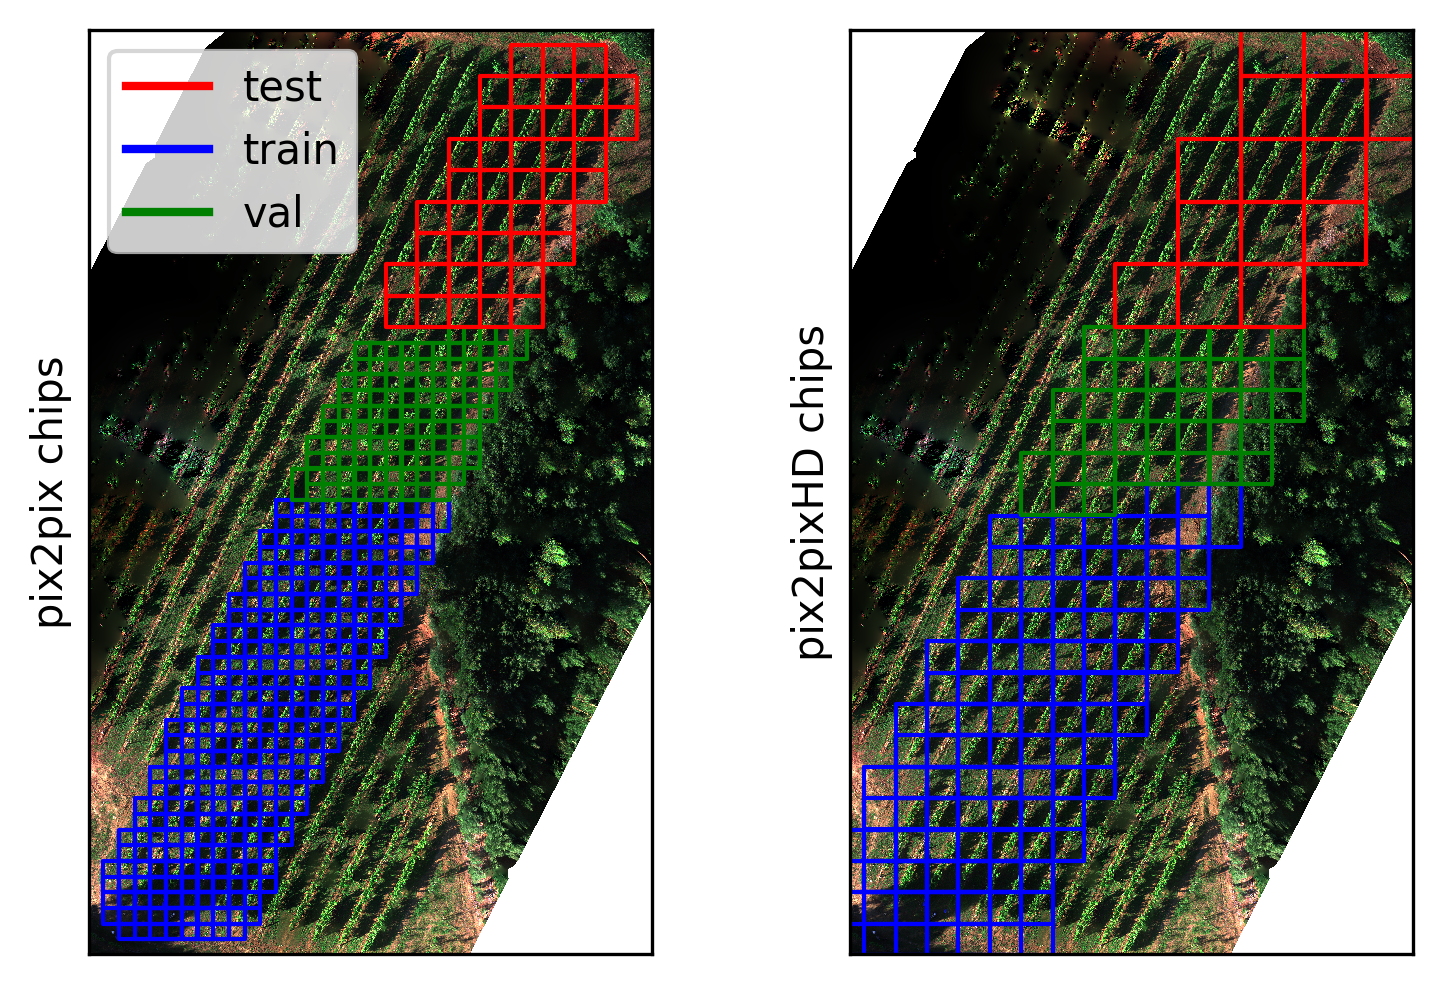

In [15]:
fig, ax = plt.subplots(dpi = 300, figsize = (6,4), ncols =2)

da.plot.imshow(ax=ax[0])
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("pix2pix chips")

train.plot(ax=ax[0], facecolor= "none", edgecolor= 'blue' ,label="train")
val.plot(ax=ax[0], facecolor= "none", edgecolor= 'green', label= "val" )
test.plot(ax=ax[0], facecolor= "none", edgecolor= 'red', label = "test" )
# we know that 
ax[0].set_ylim((train.geometry.bounds.min().miny-2,test.geometry.bounds.max().maxy+2))

ax[0].set_xlim(((train.geometry.bounds.min().minx-2,test.geometry.bounds.max().maxx+2)))

# Create custom legend labels and colors using patches
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='test'),
    plt.Line2D([0], [0], color='blue', lw=2, label='train'),
    plt.Line2D([0], [0], color='green', lw=2, label='val')
]

ax[0].legend(handles=legend_elements, loc= "upper left")

da.plot.imshow(ax=ax[1])
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pixHD chips")

trainHD.plot(ax=ax[1], facecolor= "none", edgecolor= 'blue' ,label="train")
valHD.plot(ax=ax[1], facecolor= "none", edgecolor= 'green', label= "val" )
testHD.plot(ax=ax[1], facecolor= "none", edgecolor= 'red', label = "test" )
# we know that 
ax[1].set_ylim((train.geometry.bounds.min().miny-2,test.geometry.bounds.max().maxy+2))

ax[1].set_xlim(((train.geometry.bounds.min().minx-2,test.geometry.bounds.max().maxx+2)))




plt.savefig("notebooks/figures/chips_traintestval.png", dpi =300)
plt.show()

In [16]:
print("trainHD: " , len(trainHD),
"valHD", len(valHD),
"testHD", len(testHD),
"train",len(train),
"val",len(val),
"test",len(test),
     )

trainHD:  81 valHD 26 testHD 14 train 250 val 86 test 43


In [5]:
#plot the btg2022 set

da = rxr.open_rasterio("data/orthos/rgb_2022.tif")
test= gpd.read_file("data/chips_2022v2_256.geojson")
testHD = gpd.read_file("data/rgbHD_chips2022_512.geojson")

In [6]:
#downsmaple for faster plotting
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = da.rio.width * upscale_factor
new_height = da.rio.height * upscale_factor


da =da.rio.reproject(
    da.rio.crs,
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)

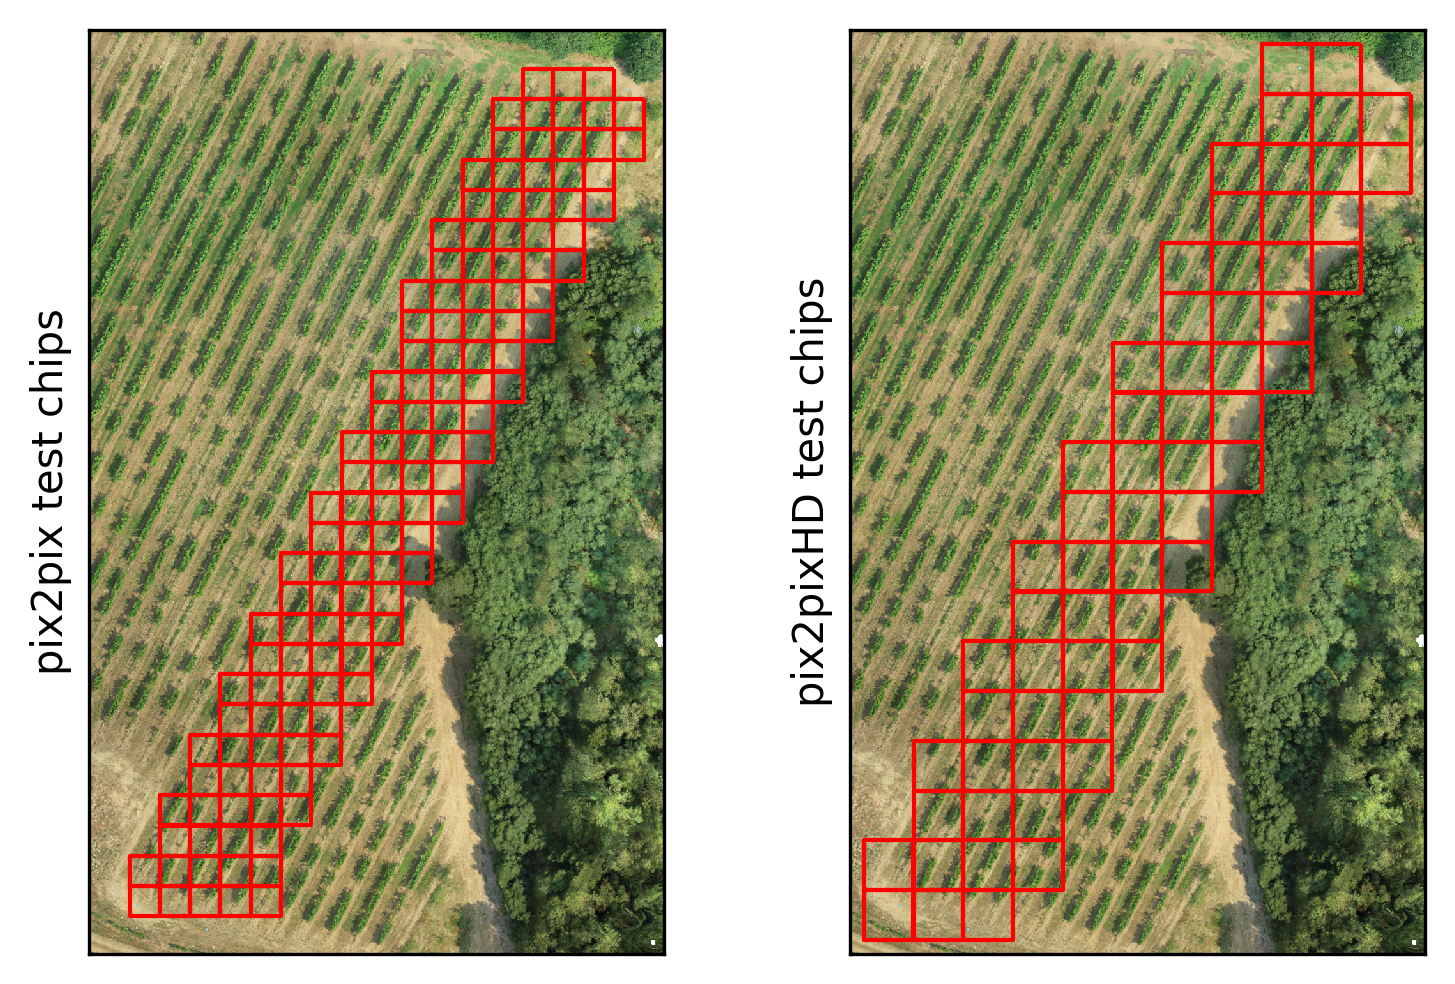

In [9]:
fig, ax = plt.subplots(dpi = 300, figsize = (6,4), ncols =2)

da.plot.imshow(ax=ax[0])
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("pix2pix test chips")

test.plot(ax=ax[0], facecolor= "none", edgecolor= 'red', label = "test" )
# we know that 
ax[0].set_ylim((testHD.geometry.bounds.min().miny-2,testHD.geometry.bounds.max().maxy+2))

ax[0].set_xlim(((testHD.geometry.bounds.min().minx-2,testHD.geometry.bounds.max().maxx+2)))

#ax[0].legend(handles=legend_elements, loc= "upper left")

da.plot.imshow(ax=ax[1])
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pixHD test chips")

testHD.plot(ax=ax[1], facecolor= "none", edgecolor= 'red', label = "test" )
# we know that 
ax[1].set_ylim((testHD.geometry.bounds.min().miny-2,testHD.geometry.bounds.max().maxy+2))

ax[1].set_xlim(((testHD.geometry.bounds.min().minx-2,testHD.geometry.bounds.max().maxx+2)))




plt.savefig("notebooks/figures/btg2022_chips_test.png", dpi =300)
plt.show()

In [10]:
print(
"testHD", len(testHD),
"test",len(test),
     )

testHD 61 test 129


In [18]:
#plot the can2023 set

da= rxr.open_rasterio("data/canyelles/orthos/rgb_230609.tif")
test= gpd.read_file("data/canyelles_chips_256.geojson")
testHD = gpd.read_file("data/canyelles_chips_512.geojson")

#downsmaple for faster plotting
from rasterio.enums import Resampling

upscale_factor =0.1
new_width = da.rio.width * upscale_factor
new_height = da.rio.height * upscale_factor
#da = da.rio.reproject("EPSG:32631")

da =da.rio.reproject(
    "EPSG:32631",
    shape=(int(new_height), int(new_width)),
    resampling=Resampling.bilinear
)


ValueError: The GeoSeries already has a CRS which is not equal to the passed CRS. Specify 'allow_override=True' to allow replacing the existing CRS without doing any transformation. If you actually want to transform the geometries, use 'GeoSeries.to_crs' instead.

In [19]:
test = test.to_crs(da.rio.crs)
testHD = testHD.to_crs(da.rio.crs)

In [20]:
print(
"testHD", len(testHD),
"test",len(test),
     )

testHD 595 test 2305


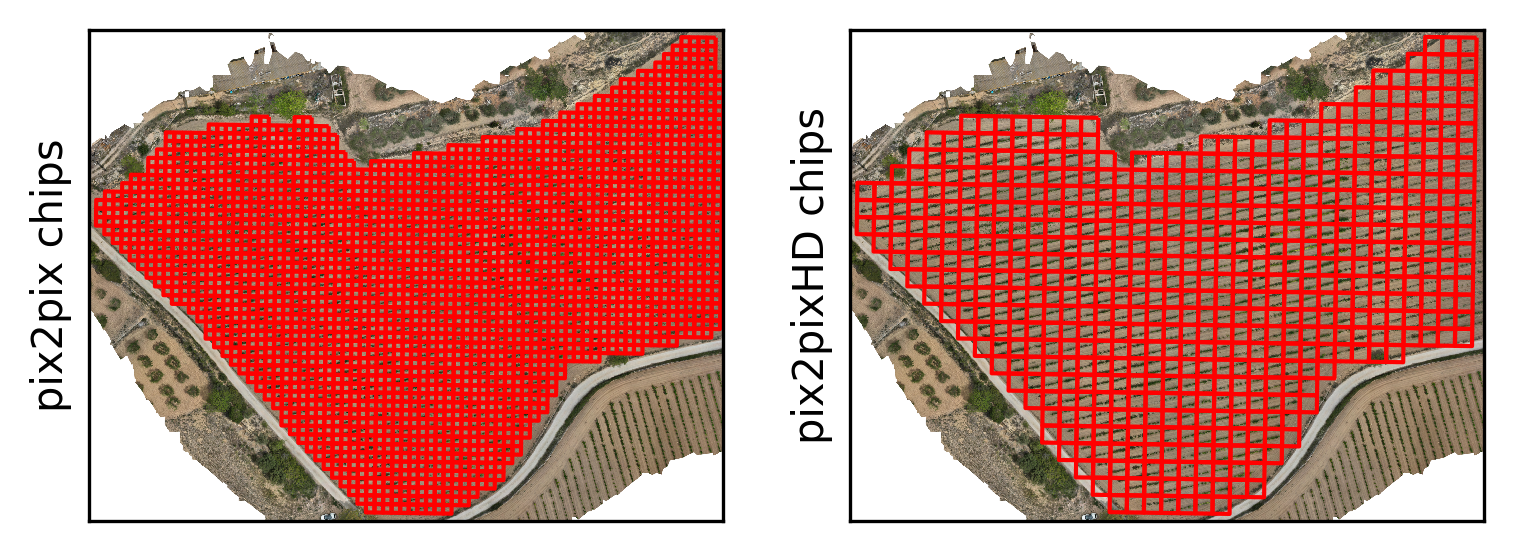

In [21]:
fig, ax = plt.subplots(dpi = 300, figsize = (6,3), ncols =2)

da.plot.imshow(ax=ax[0])
ax[0].set_title("")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_xlabel("")
ax[0].set_ylabel("pix2pix chips")

test.plot(ax=ax[0], facecolor= "none", edgecolor= 'red', label = "test" )
# we know that 
ax[0].set_ylim((testHD.geometry.bounds.min().miny-2,testHD.geometry.bounds.max().maxy+2))

ax[0].set_xlim(((testHD.geometry.bounds.min().minx-2,testHD.geometry.bounds.max().maxx+2)))


da.plot.imshow(ax=ax[1])
ax[1].set_title("")
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_xlabel("")
ax[1].set_ylabel("pix2pixHD chips")

testHD.plot(ax=ax[1], facecolor= "none", edgecolor= 'red', label = "test" )
# we know that 
ax[1].set_ylim((testHD.geometry.bounds.min().miny-2,testHD.geometry.bounds.max().maxy+2))

ax[1].set_xlim(((testHD.geometry.bounds.min().minx-2,testHD.geometry.bounds.max().maxx+2)))




plt.savefig("notebooks/figures/can2023_chips_test.png", dpi =300)
plt.show()

## 3. Actual subsetting of the imagery 
Requires the orthomosaic, coloured to nice colours and called 'da', see above.

#### Starting with the RGB: style A

In [40]:
#clip RGB set:

val_rgbs = [da.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in val.iterrows()]
train_rgbs = [da.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in train.iterrows()]
test_rgbs = [da.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in test.iterrows()]


In [41]:
# transpose to RGB instead of BANDS
val_rgbs = [np.transpose(img.values, (1,2,0)) for img in val_rgbs]
train_rgbs = [np.transpose(img.values, (1,2,0)) for img in train_rgbs]
test_rgbs = [np.transpose(img.values, (1,2,0)) for img in test_rgbs]


In [42]:
# augment the validation and train set, NOT THE TEST SET: THATS ILLEGAL

# rotate 
rot_val_rgbs = [np.rot90(img) for img in val_rgbs]
rot_train_rgbs = [np.rot90(img) for img in train_rgbs]
# flip 
flip_val_rgbs = [np.flip(img,axis=1) for img in val_rgbs]
flip_train_rgbs = [np.flip(img,axis=1) for img in train_rgbs]

val_set = val_rgbs + rot_val_rgbs + flip_val_rgbs
train_set = train_rgbs + rot_train_rgbs + flip_train_rgbs

#### repeat for NDVI: Style B

In [43]:
#clip NDVI set

val_ndvi = [ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in val.iterrows()]
train_ndvi = [ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in train.iterrows()]
test_ndvi = [ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in test.iterrows()]


In [44]:
# transpose to ndvi img
val_ndvi = [img.values for img in val_ndvi]
train_ndvi = [img.values for img in train_ndvi]
test_ndvi = [img.values for img in test_ndvi]

In [45]:
# rotate 
rot_val_ndvi = [np.rot90(img) for img in val_ndvi]
rot_train_ndvi = [np.rot90(img) for img in train_ndvi]
# flip 
flip_val_ndvi = [np.flip(img,axis=1) for img in val_ndvi]
flip_train_ndvi = [np.flip(img,axis=1) for img in train_ndvi]

val_set_ndvi = val_ndvi + rot_val_ndvi + flip_val_ndvi
train_set_ndvi = train_ndvi + rot_train_ndvi + flip_train_ndvi

In [46]:
import os
from PIL import Image

def export_image_list(path, img_list):

    for i in range(len(img_list)):
        filename = f"{i:0>{6}}" +".jpg"
        filepath = os.path.join(path, filename)
        im = Image.fromarray(img_list[i])
        im.save(filepath)

In [48]:
#Its Saving TIME
import os
# FORMAT IS EXPECTED:
path = os.path.join("data", "p2pHD_msrgb")

#for style A: aka RGB

#export:
test_path = os.path.join(path, "A", "test")
export_image_list(test_path, test_rgbs)

train_path = os.path.join(path, "A", "train")
export_image_list(train_path, train_set)

val_path = os.path.join(path, "A", "val")
export_image_list(val_path, val_set)

#for style B: aka ndvi
test_path = os.path.join(path, "B", "test")
export_image_list(test_path, test_ndvi)

train_path = os.path.join(path, "B", "train")
export_image_list(train_path, train_set_ndvi)

val_path = os.path.join(path, "B", "val")
export_image_list(val_path, val_set_ndvi)

# 4. chip the RGB 2022 dataset as well

In [1]:
# also chip the other datasets!
rgb = rxr.open_rasterio("data/orthos/rgb_2022.tif", xr_name = "rgb_sfm")
trunks = gpd.read_file("data/trunks.geojson").to_crs(rgb.rio.crs)
ms= rxr.open_rasterio("data/orthos/ms_2022.tif", xr_name = "ms_sfm")

NameError: name 'rxr' is not defined

In [76]:
def scale_band_to_min_max(band, min,max, clip =True):

    if clip:
        band = band.clip(min = min, max=max)
        
    band = band.astype(float)
    band = (band-min) * (255/(max-min))
    return band.astype(np.uint8)

In [77]:
# align NDVI to RGB:
rgb_matched = rgb.rio.reproject_match(ms).sel(band=[1,2,3])

In [78]:
# calculate NDVI values
ndvi = ug.compute.calc_ndvi(ms, red_id =4, nir_id=6, rescale= True)

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\xarray\core\duck_array_ops.py:188: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [104]:
# The image is a bit big: perhaps we can look at a small chip of the dataset for a better look:

# size of chips to be made 
input_dims = {"x": 512, "y":512}
input_overlap = {"x": 0, "y":0}

#shape (resolution) of input image
shape = rgb_matched.shape
c = rgb_matched.rio.crs
chips = ug.compute.create_chip_bounds_gdf(input_dims = input_dims, input_overlap=input_overlap, shape_x = shape[2], shape_y = shape[1], crs = c)
chips["crs_geom"] = chips["geometry"].apply(lambda x: ug.compute.imgref_to_crs(rgb_matched, x)) 
chips = chips.set_geometry(chips["crs_geom"])

In [105]:
# need to clip to the best possible dataset-section: which is in the bounds of the trunks + 3meter
# need to clip to the best possible dataset-section: which is in the bounds of the trunks + 3meter
expand = 3
offset = 40 # and add an x-offset to the data
#trunks = gpd.read_file("data/scenarioa_orchard/trunks.geojson").to_crs(rgb.rio.crs)

minx = trunks.geometry.x.min()
miny = trunks.geometry.y.min()
maxx = trunks.geometry.x.max()
maxy = trunks.geometry.y.max()

y = trunks.geometry.y[trunks.geometry.x==minx]
bl = (minx-expand,y-expand) 

x = trunks.geometry.x[trunks.geometry.y==maxy]
tl = (x-expand, maxy+expand)

y = trunks.geometry.y[trunks.geometry.x==maxx]
tr = (maxx+expand, y+expand)

x = trunks.geometry.x[trunks.geometry.y==miny]
br = (x+expand,miny-expand )


from shapely import Polygon

p = Polygon([bl,tl, tr,br])

C:\Users\judoj\mambaforge\envs\ndvi\Lib\site-packages\shapely\geometry\polygon.py:91: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


In [106]:
# find all chips that are within the intersection between the trunks-geom and themselves
#chippies = chips.set_geometry(chips["crs_geom"])
trunk_outline = gpd.GeoSeries(p,crs = rgb.rio.crs)
chips["intersects"] = chips["geometry"].apply(lambda x: trunk_outline.intersects(x))
chippies = chips[chips["intersects"]].copy()
print(len(chippies))

61


In [108]:
fig, ax = plt.subplots(dpi = 300)

#ndvi.plot(ax=ax, vmin = 0, vmax =255, cmap = "RdYlGn")

rgb_matched.plot.imshow(ax=ax)
ax.set_title("")
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("latitude")
ax.set_ylabel("longitude")

chippies.plot(ax=ax, facecolor= "none", edgecolor= 'red' ,label="test")
#val.plot(ax=ax, facecolor= "none", edgecolor= 'green', label= "val" )
#test.plot(ax=ax, facecolor= "none", edgecolor= 'red', label = "test" )
# we know that 
ax.set_ylim((chippies.geometry.bounds.min().miny-2,chippies.geometry.bounds.max().maxy+2))

ax.set_xlim(((chippies.geometry.bounds.min().minx-2,chippies.geometry.bounds.max().maxx+2)))

# Create custom legend labels and colors using patches
legend_elements = [
    plt.Line2D([0], [0], color='red', lw=2, label='test'),
]

plt.legend(handles=legend_elements, loc= "upper left")

plt.savefig("notebooks/figures/RGB2022_test_chips.png", dpi =300)
plt.show()

In [109]:
#saveit to disk
chippies.drop(columns = ["crs_geom"]).to_file("data/rgbHD_chips2022.geojson")


In [110]:
#clip RGB set:
rgbs = [rgb_matched.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in chippies.iterrows()]
#clip RGB set:
ndvis = [ndvi.rio.clip_box(minx = row.geometry.bounds[0], miny =row.geometry.bounds[1] ,maxx =row.geometry.bounds[2] , maxy= row.geometry.bounds[3]) for i, row in chippies.iterrows()]


In [111]:
# transpose to RGB instead of BANDS
rgbs = [np.transpose(img.values, (1,2,0)) for img in rgbs]
# transpose to ndvi img
ndvis = [img.values for img in ndvis]


In [112]:
import os
from PIL import Image

def export_image_list(path, img_list):

    for i in range(len(img_list)):
        filename = f"{i:0>{6}}" +".jpg"
        filepath = os.path.join(path, filename)
        im = Image.fromarray(img_list[i])
        im.save(filepath)

In [113]:
#Its Saving TIME
import os
# FORMAT IS EXPECTED:
path = os.path.join("data", "p2pHD_msrgb")

#for style A: aka RGB

train_path = os.path.join(path, "A", "test2022")
export_image_list(train_path, rgbs)

train_path = os.path.join(path, "B", "test2022")
export_image_list(train_path, ndvis)

In [114]:
# rinse and repeat for Canyelles dataset
